In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import load_and_prefilter
from src.recommenders import MainRecommender

In [2]:
filepaths = ['retail_train.csv', 'product.csv', 'hh_demographic.csv']

load_data = {'prefilter_items': True,
             'no_popular': True,
             'num_popular': 5,
             'no_unpopular': True,
             'num_unpopular': 5,
             'no_last_sales': True,
             'months_last_sales': 12,
             'not_interesting_departments':True,
             'filtered_departments': ['MISC. TRANS.'],
             'no_profit_goods': True,
             'no_expensive_goods': True}

In [3]:
data = load_and_prefilter(filepaths, load_data)
data.head()

/home/creep/Documents/Study/4q/recommendation_systems/Les06/src/utils.py:40: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  price_df = df.groupby('item_id')['quantity', 'sales_value'].sum().reset_index()
/home/creep/Documents/Study/4q/recommendation_systems/Les06/src/utils.py:47: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  price_df = df.groupby('item_id')['quantity', 'sales_value'].sum().reset_index()


,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,999999,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,999999,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,999999,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [4]:
# Избавимcя от проблемных пользователей
data = data[~data['user_id'].isin(['296', '1813', '1984', '2498'])]

In [5]:
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,999999,1,0.82,364,0.0,1631,1,0.0,0.0


In [6]:
raw_data = pd.read_csv('retail_train.csv')
raw_data_train_lvl_1 = raw_data[raw_data['week_no'] < raw_data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
raw_data_val_lvl_1 = raw_data[(raw_data['week_no'] >= raw_data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) \
                              & (raw_data['week_no'] < raw_data['week_no'].max() - (val_lvl_2_size_weeks))]

raw_data_train_lvl_2 = raw_data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
raw_data_val_lvl_2 = raw_data[raw_data['week_no'] >= raw_data['week_no'].max() - val_lvl_2_size_weeks]

result_lvl_1 = raw_data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1 = result_lvl_1[~result_lvl_1['user_id'].isin(['296', '1813', '1984', '2498'])]
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


***

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

In [7]:
recommender = MainRecommender(data_train_lvl_1)

In [8]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [9]:
%%time
result_lvl_1['pop'] = result_lvl_1['user_id'].apply \
(lambda x: popularity_recommendation(raw_data_val_lvl_1, n=25))

result_lvl_1['own_recommendations_25'] = result_lvl_1['user_id'].apply \
(lambda x: recommender.get_own_recommendations(user=x, N=25))

result_lvl_1['pop+own'] = result_lvl_1['pop'] + result_lvl_1['own_recommendations_25']

CPU times: user 25.5 s, sys: 5.65 ms, total: 25.5 s
Wall time: 25.1 s


In [10]:
result_lvl_1['pop+own'] = result_lvl_1['own_recommendations_25'] + result_lvl_1['pop']

In [11]:
%%time
result_lvl_1['als_recs'] = result_lvl_1['user_id'].apply \
(lambda x: recommender.get_als_recommendations(user=x, N=50))

CPU times: user 37.5 s, sys: 496 ms, total: 38 s
Wall time: 9.83 s


In [12]:
%%time
result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply \
(lambda x: recommender.get_own_recommendations(user=x, N=50))

CPU times: user 5.54 s, sys: 4.1 ms, total: 5.54 s
Wall time: 5.04 s


In [13]:
%%time
result_lvl_1['similar_items_recommendations'] = result_lvl_1['user_id'].apply \
(lambda x: recommender.get_similar_items_recommendation(user=x, N=50))

CPU times: user 26.4 s, sys: 268 ms, total: 26.6 s
Wall time: 6.87 s


In [14]:
%%time
result_lvl_1['similar_users_recommendations'] = result_lvl_1['user_id'].apply \
(lambda x: recommender.get_similar_users_recommendation(user=x, N=50))

CPU times: user 15min 51s, sys: 18.3 s, total: 16min 9s
Wall time: 5min 2s


In [15]:
result_lvl_1.head(2)

,user_id,actual,pop,own_recommendations_25,pop+own,als_recs,own_recommendations,similar_items_recommendations,similar_users_recommendations
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[6534178, 6533889, 1029743, 6534166, 6533765, ...","[856942, 5577022, 9297615, 9655212, 931136, 94...","[856942, 5577022, 9297615, 9655212, 931136, 94...","[1019643, 1082212, 1075074, 827261, 12263788, ...","[856942, 5577022, 9297615, 9655212, 931136, 94...","[1045586, 981760, 9526410, 1101174, 9297615, 5...","[915493, 8359154, 1092937, 900586, 7441668, 70..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[6534178, 6533889, 1029743, 6534166, 6533765, ...","[1076580, 911974, 826784, 983078, 904236, 1007...","[1076580, 911974, 826784, 983078, 904236, 1007...","[1105917, 909338, 976199, 977497, 1127831, 981...","[1076580, 911974, 826784, 983078, 904236, 1007...","[1133018, 1106523, 850529, 9526100, 1101174, 9...","[1050851, 833351, 1076580, 1121384, 869573, 10..."


In [16]:
result_lvl_1['recall@50_als_recs'] = \
result_lvl_1.apply(lambda x: recall_at_k(x['als_recs'], x['actual'], 50), axis=1)

result_lvl_1['recall@50_pop+own_recs'] = \
result_lvl_1.apply(lambda x: recall_at_k(x['pop+own'], x['actual'], 50), axis=1)

result_lvl_1['recall@50_own_recs'] = \
result_lvl_1.apply(lambda x: recall_at_k(x['own_recommendations'], x['actual'], 50), axis=1)

result_lvl_1['precision@50_own_recs'] = \
result_lvl_1.apply(lambda x: precision_at_k(x['own_recommendations'], x['actual'], 50), axis=1)

result_lvl_1['recall@50_sim_items_recs'] = \
result_lvl_1.apply(lambda x: recall_at_k(x['similar_items_recommendations'], x['actual'], 50), axis=1)

result_lvl_1['recall@50_sim_users_recs'] = \
result_lvl_1.apply(lambda x: recall_at_k(x['similar_users_recommendations'], x['actual'], 50), axis=1)

In [17]:
mp50_als_recs = result_lvl_1['recall@50_als_recs'].mean()
mp50_own_pop_recs = result_lvl_1['recall@50_als_recs'].mean()
mp50_own_recs = result_lvl_1['recall@50_own_recs'].mean()
mp50_sim_items_recs_1 = result_lvl_1['recall@50_sim_items_recs'].mean()
mp50_sim_users_recs_2 = result_lvl_1['recall@50_sim_users_recs'].mean()

In [18]:
metrics_dict = {}
metrics_dict['ALS рекомендации'] = mp50_als_recs * 100
metrics_dict['Own рекомендации'] = mp50_own_recs * 100
metrics_dict['Own + Pop рекомендации'] = mp50_own_pop_recs * 100
metrics_dict['Similar Items рекомендации'] = mp50_sim_items_recs_1 * 100
metrics_dict['Similar Users рекомендации'] = mp50_sim_users_recs_2 * 100

In [19]:
metrics_dict

{'ALS рекомендации': 5.970235215787309,
 'Own рекомендации': 8.773013868713024,
 'Own + Pop рекомендации': 5.970235215787309,
 'Similar Items рекомендации': 4.787762811737626,
 'Similar Users рекомендации': 1.3693894731535003}

***

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  

In [20]:
k = [20, 50, 100, 200, 500]

In [21]:
%%time
for el in k:
    result_lvl_1[f'own_recommendations_{el}'] = result_lvl_1['user_id'].apply \
    (lambda x: recommender.get_own_recommendations(user=x, N=el))
    
    result_lvl_1[f'recall@{el}_own_recs'] = \
    result_lvl_1.apply(lambda x: recall_at_k(x[f'own_recommendations_{el}'], x['actual'], el), axis=1)

CPU times: user 27.9 s, sys: 106 ms, total: 28 s
Wall time: 28.3 s


In [22]:
result_lvl_1.head(2)

,user_id,actual,pop,own_recommendations_25,pop+own,als_recs,own_recommendations,similar_items_recommendations,similar_users_recommendations,recall@50_als_recs,...,recall@50_sim_users_recs,own_recommendations_20,recall@20_own_recs,own_recommendations_50,own_recommendations_100,recall@100_own_recs,own_recommendations_200,recall@200_own_recs,own_recommendations_500,recall@500_own_recs
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[6534178, 6533889, 1029743, 6534166, 6533765, ...","[856942, 5577022, 9297615, 9655212, 931136, 94...","[856942, 5577022, 9297615, 9655212, 931136, 94...","[1019643, 1082212, 1075074, 827261, 12263788, ...","[856942, 5577022, 9297615, 9655212, 931136, 94...","[1045586, 981760, 9526410, 1101174, 9297615, 5...","[915493, 8359154, 1092937, 900586, 7441668, 70...",0.073394,...,0.018349,"[856942, 5577022, 9297615, 9655212, 931136, 94...",0.100917,"[856942, 5577022, 9297615, 9655212, 931136, 94...","[856942, 5577022, 9297615, 9655212, 931136, 94...",0.165138,"[856942, 5577022, 9297615, 9655212, 931136, 94...",0.220183,"[856942, 5577022, 9297615, 9655212, 931136, 94...",0.229358
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[6534178, 6533889, 1029743, 6534166, 6533765, ...","[1076580, 911974, 826784, 983078, 904236, 1007...","[1076580, 911974, 826784, 983078, 904236, 1007...","[1105917, 909338, 976199, 977497, 1127831, 981...","[1076580, 911974, 826784, 983078, 904236, 1007...","[1133018, 1106523, 850529, 9526100, 1101174, 9...","[1050851, 833351, 1076580, 1121384, 869573, 10...",0.027027,...,0.000000,"[1076580, 911974, 826784, 983078, 904236, 1007...",0.027027,"[1076580, 911974, 826784, 983078, 904236, 1007...","[1076580, 911974, 826784, 983078, 904236, 1007...",0.148649,"[1076580, 911974, 826784, 983078, 904236, 1007...",0.270270,"[1076580, 911974, 826784, 983078, 904236, 1007...",0.324324


In [23]:
metrics = []
for el in k:
    metrics.append(result_lvl_1[f'recall@{el}_own_recs'].mean()*100)

/home/creep/anaconda3/envs/gb_study/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

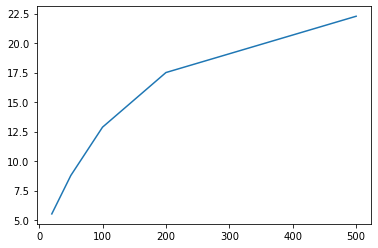

In [24]:
sns.lineplot(k , metrics)

C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

После k = 200 рост метрики сильно замедляется, так что можно остановиться на k = 200

***

### Задание 2.

Обучите модель 2-ого уровня, при этом:

    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [47]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [48]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[834103, 1085604, 1119399, 925258, 936508, 109..."
1,2021,"[1119454, 1019142, 1038462, 1074524, 969205, 8..."


In [49]:
df = pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates.values)})

In [50]:
df.head(2)

,user_id,item_id
0,2070,834103
1,2070,1085604


In [51]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)

In [52]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [53]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [54]:
# среднее кол-во покупок
avg_purchases = user_features.merge(right=data, on='user_id', how='left') \
                            .groupby(by='user_id').mean() \
                            .reset_index()[['user_id', 'quantity']] \
                            .rename(columns={'quantity': 'avg_quantity'})

user_features = user_features.merge(right=avg_purchases, on='user_id', how='left')

In [55]:
# средний чек
avg_value = user_features.merge(right=data, on='user_id', how='left') \
                            .groupby(by='user_id').mean() \
                            .reset_index()[['user_id', 'sales_value']] \
                            .rename(columns={'sales_value': 'avg_value'})

user_features = user_features.merge(right=avg_value, on='user_id', how='left')

In [56]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_quantity,avg_value
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,50.42029,2.891039
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,50.42029,2.891039


In [57]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [58]:
cat_feats = X_train.columns[1:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['item_id',
 'manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'avg_quantity',
 'avg_value']

In [59]:
%%time
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)[:, 1]

/home/creep/anaconda3/envs/gb_study/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/creep/anaconda3/envs/gb_study/lib/python3.8/site-packages/lightgbm/basic.py:814: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


CPU times: user 3.26 s, sys: 34.6 ms, total: 3.29 s
Wall time: 928 ms


In [60]:
result_lvl_2 = raw_data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2 = result_lvl_2[~result_lvl_2['user_id'].isin(['296', '1813', '1984', '2498'])]

In [61]:
recs = targets_lvl_2[['user_id', 'item_id']].copy()
recs['lgb_classifier'] = train_preds
recs.sort_values('lgb_classifier', ascending=False, inplace=True)
recs.head(2)

,user_id,item_id,lgb_classifier
5914,1609,1070820,0.960606
5915,1609,1070820,0.960606


In [62]:
top_recs = recs.groupby('user_id')['item_id'].apply(list)

In [63]:
result_lvl_2 = result_lvl_2.merge(top_recs, on=['user_id'], how='left').rename(columns={'item_id': 'lgb'})
result_lvl_2 = result_lvl_2.loc[~result_lvl_2['lgb'].isnull()]

In [64]:
result_lvl_2.head(2)

,user_id,actual,lgb
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[940947, 940947, 940947, 1075074, 9655212, 965..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1119051, 1119051, 1119051, 1119051, 900802, 9..."


In [65]:
result_lvl_2['precision@50_lgb_recs'] = \
result_lvl_2.apply(lambda x: precision_at_k(x['lgb'], x['actual'], 50), axis=1)

In [66]:
result_lvl_1['precision@50_own_recs'].mean() * 100

10.760930232558168

In [67]:
result_lvl_2['precision@50_lgb_recs'].mean() * 100

8.308254963427386